# DESAFIO ONCASE QUESTÃO 2 MODELAGEM

---

NOME: ÍCARO JOSIAS FERREIRA PAIVA

EMAIL: ijfp@cin.ufpe.br

2. Selecione um sku (produto) e realize uma previsão da demanda do mesmo nos próximos 4 intervalos de tempo de sua escolha (dia, semana, mês, etc) 

> a. métricas: rmse, mape;

> b. dados: time_series_data.xlsx;

## 0 IMPORTAÇÃO

### 0.1 IMPORTAR BIBLIOTECAS

In [1]:
import pandas                      as pd
import numpy                       as np
import matplotlib.pyplot           as plt
import seaborn                     as sns

from statsmodels.tsa.arima_model   import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics               import mean_absolute_percentage_error, mean_squared_error

### 0.2 IMPORTAR CONJUNTO DE DADOS

In [2]:
df_raw = pd.read_excel("/content/drive/MyDrive/DESAFIO/ONCASE/time_series_data.xlsx")

In [3]:
df_raw.head()

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
0,A0,23568,UN,14.13,20210420
1,A0,25082,UN,14.13,20210420
2,A0,25430,UN,14.13,20210922
3,A0,25463,UN,12.84,20210209
4,A0,25800,UN,12.84,20210209


## 1 EXPLORAÇÃO DOS DADOS

### 1.1 DESCRIÇÃO DOS DADOS

In [4]:
print('Número de amostras: {}'.format(df_raw.shape[0]))
print('Número de varaivéis: {}'.format(df_raw.shape[1]))

Número de amostras: 4460
Número de varaivéis: 5


In [5]:
df_raw.describe()

,produto_quantidade,produto_valor_unitario_comercializacao,nota_data_emissao
count,4460.000000,4460.000000,4.460000e+03
mean,424.202242,20.508176,2.020881e+07
std,2036.972760,44.426198,3.670650e+03
min,0.000000,0.620000,2.020100e+07
25%,45.000000,8.380000,2.021021e+07
50%,72.000000,11.420000,2.021043e+07
75%,183.000000,27.200000,2.021072e+07
max,42000.000000,1812.390400,2.021093e+07


In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460 entries, 0 to 4459
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   produto_descricao                       4460 non-null   object 
 1   produto_quantidade                      4460 non-null   int64  
 2   produto_unidade_comercial               4460 non-null   object 
 3   produto_valor_unitario_comercializacao  4460 non-null   float64
 4   nota_data_emissao                       4460 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 174.3+ KB


Ajustar indice do dataframe

In [7]:
#transforma de variável 'nota_data_emissao' de Int para Datetime
df_raw['nota_data_emissao'] = pd.to_datetime(df_raw['nota_data_emissao'], format='%Y%m%d')

# Ordenar o datagframe em ordem cronológica
df_raw=df_raw.sort_values(by='nota_data_emissao')

# Tornar variavel 'nota_data_emissao' em indice do dataframe
df_raw = df_raw.set_index('nota_data_emissao')

In [8]:
df_raw.head()

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao
nota_data_emissao,,,,
2020-10-01,A9,5,UN,134.11
2020-10-01,B0,120,UN,29.50
2020-10-01,B3,24,UN,3.19
2020-10-02,A8,1,UN,1.90
2020-10-02,B4,7,UN,1.74


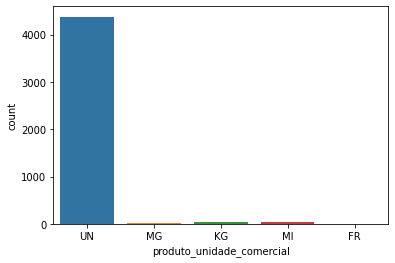

In [9]:
sns.countplot(data=df_raw, x='produto_unidade_comercial');

Temos a unidade de medida UN o mais usado.

### 1.2 AVALIAÇÃO DAS VARIÁVEIS

In [10]:
# Lista crescente das frequencias das demandas dos produtos

count_produtos = df_raw['produto_descricao'].value_counts()
main_count_produtos = []
for i in range(len(count_produtos)):
    if count_produtos[i] > 500:
        main_count_produtos.append(count_produtos.index[i])

In [11]:
print('Os produtos %s aparecem em mais de 500 demandas ao lono do tempo' %main_count_produtos)

Os produtos ['B0', 'B3', 'B2', 'A8', 'B1'] aparecem em mais de 500 demandas ao lono do tempo


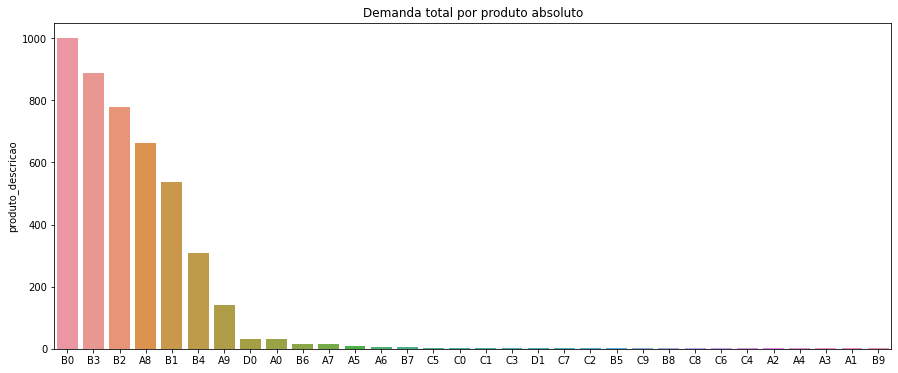

In [12]:
# Grafico com número absolutos e a frenquência acumulada de demanda por produto

ax1 = sns.set_style(style=None, rc=None)
fig, ax1 = plt.subplots(figsize=(15,6))
plt.title('Demanda total por produto absoluto')
sns.barplot(x=count_produtos.index, y=count_produtos,  ci=None, ax=ax1);

5 produtos são responsáveis por mais de 80% das demandas

In [13]:
# Retirada de produtos com baixa demanda

size_main = len(main_count_produtos)
df = df_raw.copy()
for i in range(len(count_produtos)-size_main):
    df = df[~df['produto_descricao'].str.contains(count_produtos.index[-(len(count_produtos)-i-size_main)])]

Para decidir qual dos produtos com demanda alta será avaliado será usado aquele que movimentar. Para isso, será criado uma nova variavel com combinando o valor unitario com a demanda por produto.

In [14]:
# Criação da Variável 'valor_total'

df['valor_total'] = df['produto_quantidade']*df['produto_valor_unitario_comercializacao']

In [15]:
df.head()

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,valor_total
nota_data_emissao,,,,,
2020-10-01,B0,120,UN,29.50,3540.00
2020-10-01,B3,24,UN,3.19,76.56
2020-10-02,A8,1,UN,1.90,1.90
2020-10-02,B2,6,UN,2.78,16.68
2020-10-02,B2,3,UN,2.40,7.20


In [16]:
# Retirada das variáveis que não serão mais usadas 'produto_unidade_comercial','produto_valor_unitario_comercializacao','produto_quantidade'

df2 = df.loc[:, ~df.columns.isin(['produto_unidade_comercial','produto_valor_unitario_comercializacao','produto_quantidade'])]

In [17]:
# Calculo dos produtos com maior valor de venda total

valor_total_prod = df2.groupby('produto_descricao').sum().sort_values(by='valor_total', ascending=False)
valor_total_prod_perc = (valor_total_prod/valor_total_prod.sum())

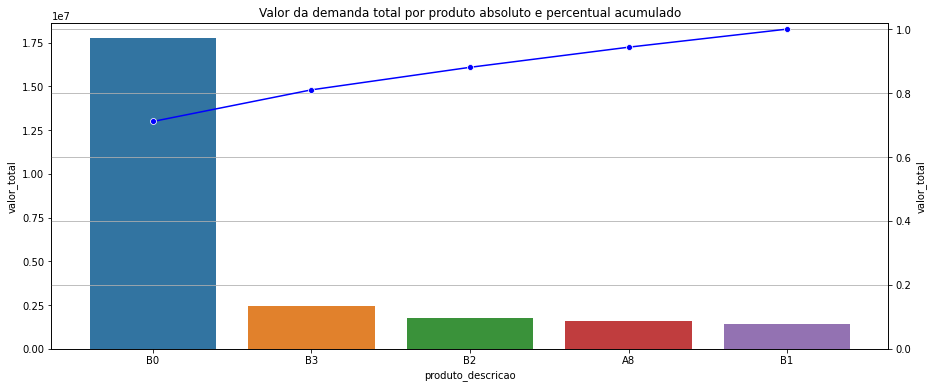

In [18]:
# Grafico com valores absolutos e a frenquência acumulada de demanda por produto

ax1 = sns.set_style(style=None, rc=None)
fig, ax1 = plt.subplots(figsize=(15,6))
plt.title('Valor da demanda total por produto absoluto e percentual acumulado')
sns.barplot(x=valor_total_prod.index, y=valor_total_prod['valor_total'],  ci=None, ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(x=valor_total_prod.index, y= valor_total_prod_perc.cumsum()['valor_total'], marker='o',ax = ax2, color='b')
ax2.set_ylim(0, 1.02)
ax2.yaxis.grid(True)

In [19]:
print('O produto %s apresenta %i entradas e representa %0.2f da valor da movimentação dos %i produtos com mais demandas. \nPor isso, será escolhido o produto escolhido para fazer analises e previsões.' % (valor_total_prod.index[0],  int(np.array(count_produtos)[0]) , float(np.array(valor_total_prod_perc)[0]), len(main_count_produtos)))

O produto B0 apresenta 1000 entradas e representa 0.71 da valor da movimentação dos 5 produtos com mais demandas. 
Por isso, será escolhido o produto escolhido para fazer analises e previsões.


## 2 PREPARAÇÃO DOS DADOS

### 2.1 SEPARAÇÃO DA SERIE

Para o estudo de previsão da demanda será excluido as variaveis 'produto_unidade_comercial' e 'produto_valor_unitario_comercializacao'

In [20]:
# excluir variaveis 

df = df.loc[:, ~df.columns.isin(['produto_unidade_comercial','produto_valor_unitario_comercializacao','valor_total'])]

In [21]:
df.head()

,produto_descricao,produto_quantidade
nota_data_emissao,,
2020-10-01,B0,120
2020-10-01,B3,24
2020-10-02,A8,1
2020-10-02,B2,6
2020-10-02,B2,3


isolar serie temporal do Produto B0 

In [22]:
# Criando dataframe do produto B0
df_b0 = df[df['produto_descricao'].str.contains(count_produtos[:].index[0]) == True]
df_b0 = df_b0.loc[:,~df_b0.columns.isin(['produto_descricao'])]

# Reamostrar em termos de mês, semana e dia
df_b0_m = df_b0.resample('M').sum() # serie agregada mensalmente
df_b0_w = df_b0.resample('W').sum() # serie agregada semanalemente
df_b0_d = df_b0.resample('D').sum() # serie agregada diariamente

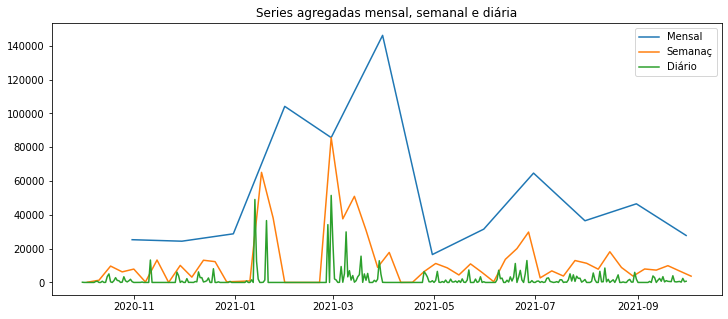

In [23]:
# plot da serie agregadas mensal, semanal e diária'

plt.figure(figsize=(12, 5))
plt.title('Series agregadas mensal, semanal e diária')
plt.plot(df_b0_m,label='Mensal')
plt.plot(df_b0_w,label='Semanaç')
plt.plot(df_b0_d,label='Diário')
plt.legend()
plt.show()

Por ter mais amostras e para diminuir efeitos da sazionalidade foi escolhida a serie diária para previsão

### 2.3 DIVISÃO TREINAMENTO E TESTE

In [24]:
# divisão treino e teste (previsão para 4)

df_b0_d = np.array(df_b0_d)

pred_size = 4
train_size = len(df_b0_d) - pred_size
train = df_b0_d[0:train_size,:]
test = df_b0_d[-pred_size:]
print('train_size : %i, test_size: %i'%(len(train),len(test)))

train_size : 361, test_size: 4


## 3 MODELAGEM

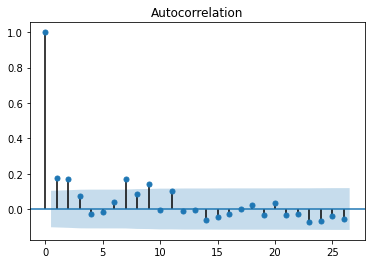

In [25]:
plot_acf(train);

Apenas duas componentes tem valor com alguma significância (MA:2)

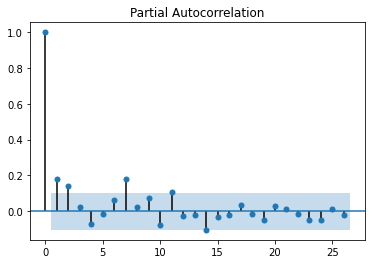

In [26]:
plot_pacf(train);

Assim como no anterior, apenas duas componentes se mostram alguma relevancia (AR:2)

In [ ]:
# Treinamento do modelo

arima = ARIMA(train, order=(2, 0, 2))
arima_fit = arima.fit()

## 4 RESULTADOS

In [28]:
#  Previsão da série

predicted = arima_fit.predict(len(train), len(train)+pred_size-1)

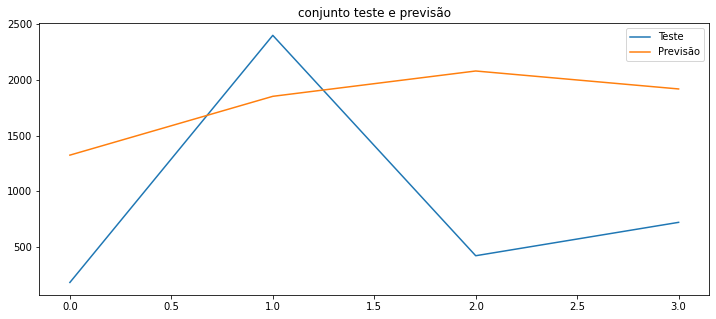

In [29]:
# plot teste e previsão

plt.figure(figsize=(12, 5))
plt.title('conjunto teste e previsão')
plt.plot(test,label='Teste')
plt.plot(predicted, label='Previsão')
plt.legend()
plt.show()

In [30]:
print('Para o Conjunto de Teste temos MAPE: %.2f e RMSE: %0.2f' %(mean_absolute_percentage_error(test, predicted), mean_squared_error(test, predicted, squared=False)))


Para o Conjunto de Teste temos MAPE: 3.05 e RMSE: 1204.12


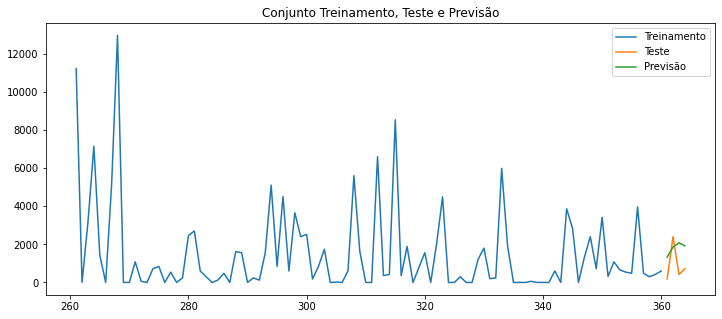

In [31]:
# plot treinamneto, teste, previsão

df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test, index=range(len(train),len(train)+pred_size))
df_pred = pd.DataFrame(predicted, index=range(len(train),len(train)+pred_size))


plt.figure(figsize=(12, 5))
plt.title('Conjunto Treinamento, Teste e Previsão')
plt.plot(df_train[-100:], label='Treinamento')
plt.plot(df_test,label='Teste')
plt.plot(df_pred, label='Previsão')
plt.legend()
plt.show()

O resultados indicam que o modelo não foi capaz de aprender os padrões do conjunto com tanta precisão. É interessante reavaliar escolhas do conjuto de dados e também buscar outros modelos que possam se adaptar a natureza do dados.